# Datan skaalauksen tarkistus ja toteutus

Tässä notebookissa käsitellään hydraulisen järjestelmän mittausdataa koneoppimista varten:
1. Analysoidaan datan skaalaustarpeita
2. Toteutetaan datan skaalaus
3. Tallennetaan skaalattu data ja skaalausparametrit

## 1. Kirjastojen tuonti
- pandas: Datan käsittelyyn ja analysointiin
- numpy: Numeeriseen laskentaan
- matplotlib ja seaborn: Visualisointiin
- sklearn.preprocessing: Datan skaalaukseen
- joblib: Mallin tallentamiseen

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import joblib
import sys

# Remove the maximum column limit
pd.set_option('display.max_columns', None)
# Remove the maximum row limit
pd.set_option('display.max_rows', None)
# Set the display width to fit your screen
pd.set_option('display.width', None)
# Remove the maximum string length limit
sys.set_int_max_str_digits(0)  # Poista numeroiden tulostusrajoitus

## 2. Datan lataus ja analysointi

Analysoidaan datan tilastolliset ominaisuudet skaalauksen suunnittelua varten:
- Minimi- ja maksimiarvot: Kertovat muuttujien arvoalueet
- Keskiarvo ja mediaani: Kuvaavat datan keskimääräistä tasoa
- Keskihajonta: Kuvaa arvojen vaihtelua keskiarvon ympärillä
- Arvoalue: Kertoo muuttujan kokonaisvaihtelun

Nämä tiedot ovat tärkeitä, koska:
1. Suuret erot arvoalueissa voivat haitata koneoppimismallien toimintaa
2. Keskiarvojen ja -hajontojen erot kertovat tarpeesta normalisoida data

In [2]:
# Lue puhdistettu data
input_file = '../Data/cleanHydraulicData.csv'
print(f"\nLuetaan data tiedostosta: {input_file}")
df = pd.read_csv(input_file)

# Analysoi numeeriset sarakkeet
numeric_cols = ['pumpControl', 'pressure']

print("\nMUUTTUJIEN STATISTIIKKA:")
print("------------------------")
for col in numeric_cols:
    stats = df[col].describe()
    print(f"\n{col}:")
    print(f"Minimi:     {stats['min']:.2f}")
    print(f"Maksimi:    {stats['max']:.2f}")
    print(f"Keskiarvo:  {stats['mean']:.2f}")
    print(f"Mediaani:   {stats['50%']:.2f}")
    print(f"Keskihaj.:  {stats['std']:.2f}")
    print(f"Arvoalue:   {stats['max'] - stats['min']:.2f}")


Luetaan data tiedostosta: ../Data/cleanHydraulicData.csv

MUUTTUJIEN STATISTIIKKA:
------------------------

pumpControl:
Minimi:     18.00
Maksimi:    100.00
Keskiarvo:  71.32
Mediaani:   72.00
Keskihaj.:  22.35
Arvoalue:   82.00

pressure:
Minimi:     1.00
Maksimi:    432.00
Keskiarvo:  193.11
Mediaani:   176.00
Keskihaj.:  113.31
Arvoalue:   431.00


## 3. Skaalaussuositukset

Analysoidaan datan ominaisuuksia skaalauksen kannalta:

### Miksi skaalaus on tärkeää?
1. Koneoppimismallit toimivat paremmin, kun muuttujat ovat samassa mittakaavassa
2. Gradienttipohjainen optimointi konvergoi nopeammin
3. Vältytään numeerisiltä ongelmilta

### Valittu skaalausmenetelmä
Käytetään MinMaxScaler-menetelmää, koska:
- Skaalaa arvot välille [0,1]
- Säilyttää nollan arvot ja jakauman muodon
- Sopii hyvin neuroverkoille ja muille malleille

In [3]:
# Tarkista arvoalueiden erot
ranges = {col: df[col].max() - df[col].min() for col in numeric_cols}
max_range = max(ranges.values())
min_range = min(ranges.values())
range_ratio = max_range / min_range

print("\nSKAALAUSSUOSITUKSET:")
print("------------------------")

if range_ratio > 2:
    print(f"\n1. Arvoalueiden suhde on ({range_ratio:.1f}x):")
    for col in numeric_cols:
        print(f"   - {col}: {ranges[col]:.1f}")

# Tarkista keskiarvojen ja keskihajontojen erot
means = {col: df[col].mean() for col in numeric_cols}
stds = {col: df[col].std() for col in numeric_cols}

max_mean = max(means.values())
min_mean = min(means.values())
mean_ratio = max_mean / min_mean

if mean_ratio > 2:
    print(f"\n2. Keskiarvojen suhde on ({mean_ratio:.1f}x):")
    for col in numeric_cols:
        print(f"   - {col}: keskiarvo = {means[col]:.1f}, keskihajonta = {stds[col]:.1f}")


SKAALAUSSUOSITUKSET:
------------------------

1. Arvoalueiden suhde on (5.3x):
   - pumpControl: 82.0
   - pressure: 431.0

2. Keskiarvojen suhde on (2.7x):
   - pumpControl: keskiarvo = 71.3, keskihajonta = 22.3
   - pressure: keskiarvo = 193.1, keskihajonta = 113.3


## 4. Datan skaalaus

### MinMaxScaler toiminta:
1. Laskee jokaiselle muuttujalle:
   - X_scaled = (X - X_min) / (X_max - X_min)
2. Tuloksena arvot välillä [0,1]:
   - Alkuperäinen minimi -> 0
   - Alkuperäinen maksimi -> 1
   - Muut arvot skaalautuvat lineaarisesti välille

### Tärkeää huomioida:
- Samat skaalausparametrit pitää käyttää myöhemmin uudelle datalle
- Tallennetaan scaler myöhempää käyttöä varten

In [4]:
# Skaalaa numeeriset sarakkeet
print("\nSkaalataan data...")
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df[numeric_cols])




Skaalataan data...


## 5. Tilamuuttujien käsittely

### Tilojen numeerinen koodaus:
- normal_digging = 0 (normaali kaivuu)
- normal_full = 1 (normaali täysi)
- normal_empty = 2 (normaali tyhjä)
- overload = 3 (ylikuorma)
- hose_break = 4 (letkurikko)

### One-hot-koodauksen tarkoitus:
1. Muuntaa kategorisen muuttujan numeeriseen muotoon
2. Välttää virheellisen järjestyksen luominen tilojen välille
3. Mahdollistaa tilojen riippumattoman käsittelyn mallissa

### Tuloksena:
- Jokainen tila saa oman sarakkeensa (True/False)
- Vain yksi tila voi olla aktiivinen kerrallaan


KÄSITELLÄÄN TILAMUUTTUJAT:
------------------------

Alkuperäiset tilat:
state
normal_digging    3661
overload          2981
normal_full       1193
normal_empty      1099
hose_break         990
Name: count, dtype: int64

Tilojen jakaumat:
state_numeric           16294
state_hose_break          990
state_normal_digging     3661
state_normal_empty       1099
state_normal_full        1193
state_overload           2981
dtype: int64


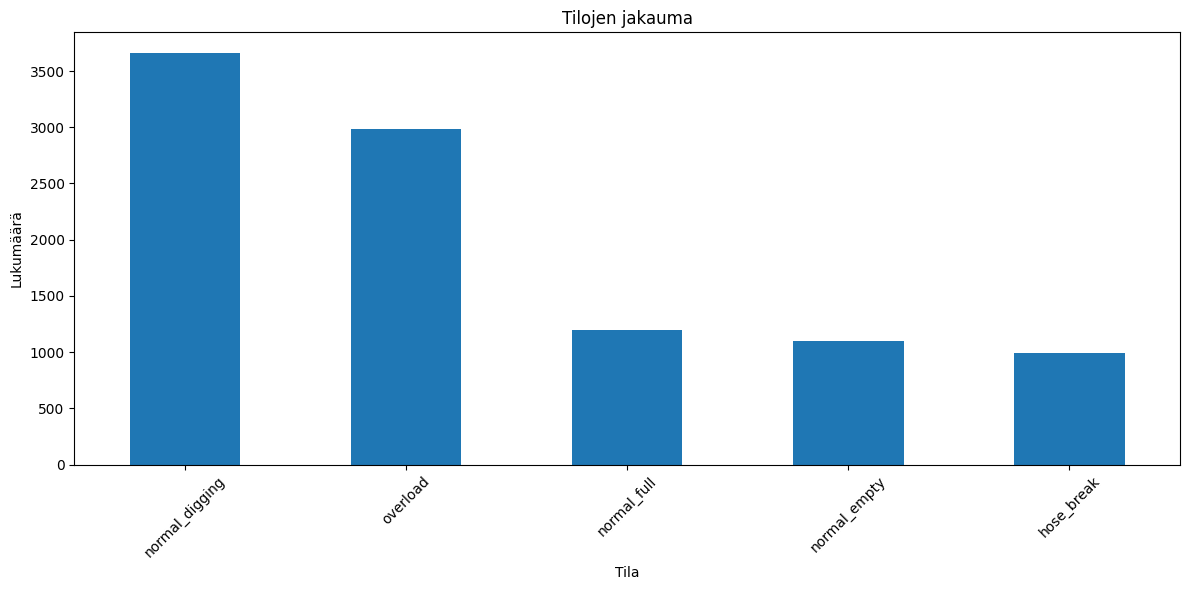

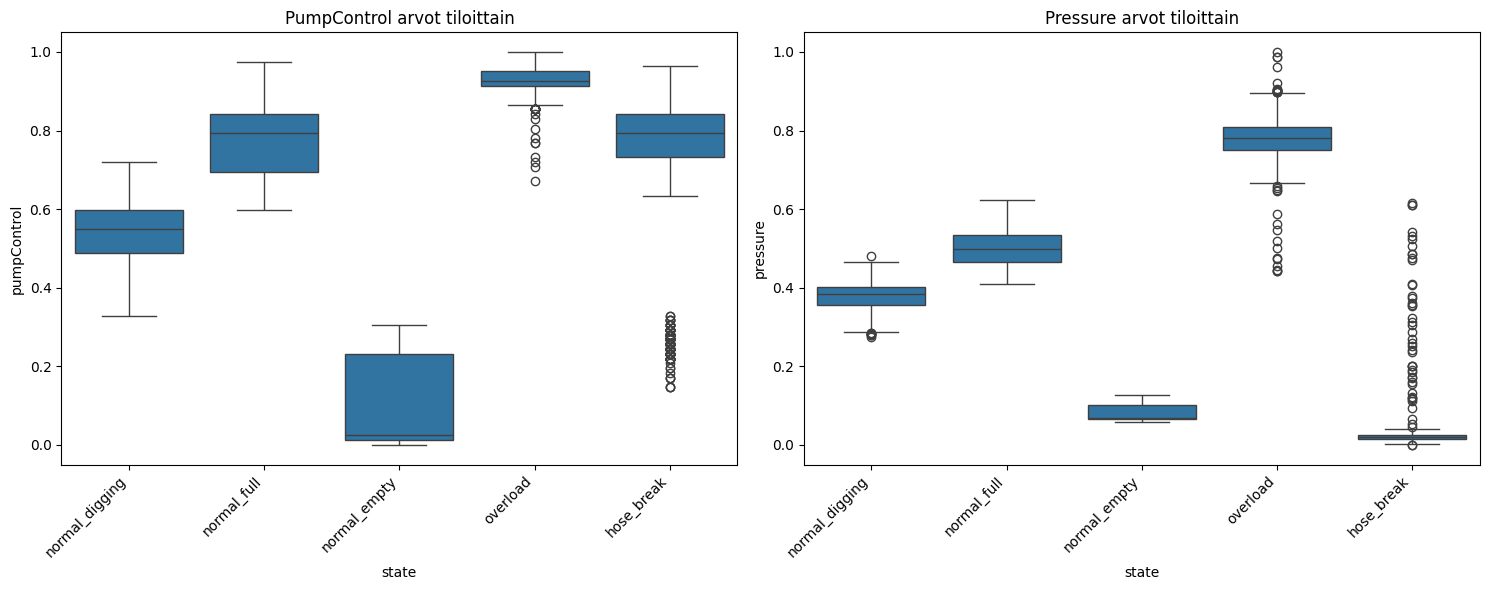


TILOJEN KÄSITTELYN YHTEENVETO:
------------------------
1. Tilat on muunnettu numeerisiksi arvoiksi:
   - normal_digging: 0
   - normal_full: 1
   - normal_empty: 2
   - overload: 3
   - hose_break: 4

2. One-hot koodatut tilasarakkeet on lisätty:
   - state_numeric
   - state_hose_break
   - state_normal_digging
   - state_normal_empty
   - state_normal_full
   - state_overload

3. Visualisoinnit on tallennettu:
   - Tilojen jakauma: ../Visualization/stateDistribution.png
   - Tilojen suhde muuttujiin: ../Visualization/stateFeatureRelationships.png


In [5]:
# 5. Tilamuuttujien käsittely koneoppimista varten
print("\nKÄSITELLÄÄN TILAMUUTTUJAT:")
print("------------------------")

df = df_scaled

# Tarkista nykyiset tilat
print("\nAlkuperäiset tilat:")
print(df['state'].value_counts())

# Muunna tilat numeerisiksi arvoiksi
state_mapping = {
    'normal_digging': 0,  # normaali kaivuu
    'normal_full': 1,     # normaali täysi
    'normal_empty': 2,    # normaali tyhjä
    'overload': 3,        # ylikuorma
    'hose_break': 4       # letkurikko
}

df['state_numeric'] = df['state'].map(state_mapping)

# Luo one-hot koodaus
state_dummies = pd.get_dummies(df['state'], prefix='state')
df = pd.concat([df, state_dummies], axis=1)

# Näytä tilojen jakaumat
print("\nTilojen jakaumat:")
print(df[[col for col in df.columns if col.startswith('state_')]].sum())

# Visualisoi tilojen jakauma
plt.figure(figsize=(12, 6))
df['state'].value_counts().plot(kind='bar')
plt.title('Tilojen jakauma')
plt.xlabel('Tila')
plt.ylabel('Lukumäärä')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../Visualization/stateDistribution.png')
plt.show()

# Visualisoi tilojen suhde muuttujiin
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# PumpControl vs. tila
sns.boxplot(data=df, x='state', y='pumpControl', ax=axes[0])
axes[0].set_title('PumpControl arvot tiloittain')
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, ha='right')

# Pressure vs. tila
sns.boxplot(data=df, x='state', y='pressure', ax=axes[1])
axes[1].set_title('Pressure arvot tiloittain')
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')

# Säädä asettelua niin että käännetyt tekstit mahtuvat
plt.tight_layout()
plt.savefig('../Visualization/stateFeatureRelationships.png', bbox_inches='tight')
plt.show()

print("\nTILOJEN KÄSITTELYN YHTEENVETO:")
print("------------------------")
print("1. Tilat on muunnettu numeerisiksi arvoiksi:")
for state, num in state_mapping.items():
    print(f"   - {state}: {num}")
print("\n2. One-hot koodatut tilasarakkeet on lisätty:")
for col in df.columns:
    if col.startswith('state_'):
        print(f"   - {col}")
print("\n3. Visualisoinnit on tallennettu:")
print("   - Tilojen jakauma: ../Visualization/stateDistribution.png")
print("   - Tilojen suhde muuttujiin: ../Visualization/stateFeatureRelationships.png")

## 6. Datan tallennus

### Tallennettavat tiedostot:
1. Skaalattu data (scaledHydraulicData.csv):
   - Sisältää skaalatut numeeriset muuttujat
   - Sisältää alkuperäiset ja koodatut tilat
   - CSV-muoto yhteensopivuuden vuoksi

2. Skaalausparametrit (hydraulicScaler.joblib):
   - Sisältää MinMaxScaler-objektin
   - Tarvitaan uuden datan skaalaukseen
   - Varmistaa yhdenmukaisen skaalauksen

### Validointi:
- Tarkista skaalattujen arvojen rajat (0-1)
- Varmista one-hot-koodauksen oikeellisuus
- Testaa scaler-objektin toiminta

In [6]:
# Määritä tiedostopolut
output_file = '../Data/scaledHydraulicData.csv'
scaler_file = '../Models/hydraulicScaler.joblib'

# Tallenna käsitelty data CSV-tiedostoksi
df.to_csv(output_file, index=False)
print(f"\n4. Käsitelty data on tallennettu: {output_file}")

# Tallenna scaler myöhempää käyttöä varten
print("Tallennetaan scaler myöhempää käyttöä varten...")
joblib.dump(scaler, scaler_file)

# Tulosta skaalatut tilastot
print("\nSKAALATTU DATA:")
print("--------------------")
for col in numeric_cols:
    stats = df_scaled[col].describe()
    print(f"\n{col}:")
    print(f"Minimi:     {stats['min']:.2f}")
    print(f"Maksimi:    {stats['max']:.2f}")
    print(f"Keskiarvo:  {stats['mean']:.2f}")
    print(f"Keskihaj.:  {stats['std']:.2f}")

print("\nSkaalauksen yhteenveto:")
print("--------------------")
print("1. Kaikki arvot on skaalattu välille [0,1]")
print("2. Skaalaustiedot tallennettu tiedostoon:", scaler_file)
print("3. Skaalattu data tallennettu tiedostoon:", output_file)

print("\nMuunnokset:")
for col, scale_params in zip(numeric_cols, zip(scaler.min_, scaler.scale_)):
    min_val, scale = scale_params
    print(f"\n{col}:")
    print(f"x_scaled = (x - {-min_val:.3f}) * {scale:.6f}")

print("\nSkaalaus valmis!")


4. Käsitelty data on tallennettu: ../Data/scaledHydraulicData.csv
Tallennetaan scaler myöhempää käyttöä varten...

SKAALATTU DATA:
--------------------

pumpControl:
Minimi:     0.00
Maksimi:    1.00
Keskiarvo:  0.65
Keskihaj.:  0.27

pressure:
Minimi:     0.00
Maksimi:    1.00
Keskiarvo:  0.45
Keskihaj.:  0.26

Skaalauksen yhteenveto:
--------------------
1. Kaikki arvot on skaalattu välille [0,1]
2. Skaalaustiedot tallennettu tiedostoon: ../Models/hydraulicScaler.joblib
3. Skaalattu data tallennettu tiedostoon: ../Data/scaledHydraulicData.csv

Muunnokset:

pumpControl:
x_scaled = (x - 0.220) * 0.012195

pressure:
x_scaled = (x - 0.002) * 0.002320

Skaalaus valmis!
